# Attention

In [1]:
import math
import random
import copy

import sentencepiece as spm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import (
    pad_sequence,
    pack_padded_sequence,
    pad_packed_sequence,
)
from dlprog import train_progress
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
prog = train_progress(
    width=20,
    with_test=True,
    label="ppl train",
    round=2,
    agg_fn=lambda s, w: math.exp(s / w)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
textfile_ja = "data/iwslt2017_ja.txt"
textfile_en = "data/iwslt2017_en.txt"
tokenizer_prefix_ja = f"models/tokenizer_iwslt2017_ja"
tokenizer_prefix_en = f"models/tokenizer_iwslt2017_en"

with open(textfile_en) as f:
    data_en = f.read().splitlines()

with open(textfile_ja) as f:
    data_ja = f.read().splitlines()

n_data = len(data_en)
print("num of data:", n_data)

sp_ja = spm.SentencePieceProcessor(f"{tokenizer_prefix_ja}.model")
sp_en = spm.SentencePieceProcessor(f"{tokenizer_prefix_en}.model")
unk_id = sp_ja.unk_id()
bos_id = sp_ja.bos_id()
eos_id = sp_ja.eos_id()
pad_id = sp_ja.pad_id()
n_vocab_ja = len(sp_ja)
n_vocab_en = len(sp_en)
print("num of vocabrary (ja):", n_vocab_ja)
print("num of vocabrary (en):", n_vocab_en)

num of data: 223108
num of vocabrary (ja): 8000
num of vocabrary (en): 8000


In [4]:
data_ids_ja = sp_ja.encode(data_ja)
data_ids_en = sp_en.encode(data_en)

for ids_ja, ids_en in zip(data_ids_ja, data_ids_en):
    ids_ja.append(eos_id)
    ids_en.insert(0, bos_id)
    ids_en.append(eos_id)

In [5]:
class TextDataset(Dataset):
    def __init__(self, data_ids_ja, data_ids_en):
        self.data_ja = [torch.tensor(ids) for ids in data_ids_ja]
        self.data_en = [torch.tensor(ids) for ids in data_ids_en]
        self.n_data = len(self.data_ja)

    def __getitem__(self, idx):
        ja = self.data_ja[idx]
        en = self.data_en[idx]
        x_enc = ja
        x_dec = en[:-1]
        y_dec = en[1:]
        return x_enc, x_dec, y_dec

    def __len__(self):
        return self.n_data

def collate_fn(batch):
    x_enc, x_dec, y_dec= zip(*batch)
    x_enc = pad_sequence(x_enc, batch_first=True, padding_value=pad_id)
    x_dec = pad_sequence(x_dec, batch_first=True, padding_value=pad_id)
    y_dec = pad_sequence(y_dec, batch_first=True, padding_value=pad_id)
    return x_enc, x_dec, y_dec

dataset = TextDataset(data_ids_ja, data_ids_en)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print("num of train data:", len(train_dataset))
print("num of test data:", len(test_dataset))

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    drop_last=True,
    collate_fn=collate_fn
)

x_enc, x_dec, y_dec = next(iter(train_loader))
x_enc.shape, x_dec.shape, y_dec.shape

num of train data: 178487
num of test data: 44621


(torch.Size([32, 52]), torch.Size([32, 52]), torch.Size([32, 52]))


---

## Attention機構

複数のデータの中から重要なデータに着目する仕組み。Attention = 注意、注目、着目。

ある一つの入力と、関連する複数のデータを考える。関連する複数のデータはmemoryと呼ぶ。入力を元に、memoryの中のどのデータに着目するかを定めることがAttentionの目的である。各データに重要度を割り当てるという感じ。

重要度は重みと呼ばれ、$w_i$で表すことにする。重みは総和が1になるようにsoftmaxなどで正規化する。正規化前の値はスコアと呼んだりする。

各memoryに対応する重みは入力との内積で求める。別に内積じゃなくてもいいけど、内積が一番簡単だし性能も良い。内積が取れるように、memoryの各ベクトルは入力と同じ次元にする必要がある。

重みを求めた後は、その重みでmemoryの重み付き和をとる。そうすることで、memoryの中から重要な要素を多めに取り出した固定長のベクトルが得られる。

やってみよう。まず、入力と、三つのデータからなるmemoryを用意する。

In [6]:
n, d = 3, 5

x = torch.randn(d)
memory = torch.randn(n, d)
memory

tensor([[ 0.7003,  0.3728,  0.9630, -0.7548,  1.4186],
        [-0.3834,  0.7128, -0.5010, -0.5049,  0.4977],
        [-0.0481,  0.5967,  2.3803,  0.1163,  0.1539]])

入力とmemory内の全てのデータで内積を取る。これがスコアに当たる。

In [7]:
scores = torch.tensor([m @ x for m in memory])
scores

tensor([0.3264, 0.1925, 0.4811])

これでもいい。

In [ ]:
scores = x @ memory.T
scores

softmaxで正規化する。

In [ ]:
weights = F.softmax(scores, dim=-1)
weights

この重みがmemoryの各データの重要度を表す。これで重み付き和をとる。

In [8]:
# 重みをかける
weighted_memory = torch.stack([w * m for w, m in zip(weights, memory)])
weighted_memory

tensor([[ 0.2286,  0.1217,  0.3143, -0.2464,  0.4630],
        [-0.0738,  0.1372, -0.0964, -0.0972,  0.0958],
        [-0.0231,  0.2871,  1.1452,  0.0560,  0.0740]])

In [9]:
# 和をとる
y = weighted_memory.sum(dim=0)
y

tensor([ 0.1316,  0.5460,  1.3631, -0.2876,  0.6329])

以下のようにまとめられる。

In [10]:
y = weights @ memory # 重み付き和
y

tensor([ 0.1316,  0.5460,  1.3631, -0.2876,  0.6329])

以上がattention機構の演算の流れである。まとめるとこう。

In [11]:
scores = memory @ x # スコア
weights = F.softmax(scores, dim=-1) # 重み
y = weights @ memory # 重み付き和
y

tensor([ 0.1316,  0.5460,  1.3631, -0.2876,  0.6329])

数式だとこうなる。

$$
\text{Attention}(\boldsymbol x,M) = \text{softmax}(\boldsymbol xM^T)M
$$

- $\boldsymbol x\in\mathbb R^{d}$ : 入力
- $M\in\mathbb R^{n\times d}$ : memory

\*列ベクトルと行ベクトルを区別していないので厳密ではない。厳密に書くならこう:

$$
\text{Attention}(\boldsymbol x,M) = (\text{softmax}(\boldsymbol x^TM^T)M)^T
$$


---

## Attentionを用いたSeq2Seq

Seq2SeqにAttentionを導入し、Encoderが出力した全ての隠れ状態をDecoderから参照する。

DecoderにAttentionを取り入れる。入力は前の層からの出力で、memoryはEncoderが出力した全ての隠れ状態である。こうすることで、Decoderは各時刻でその時着目すべき情報に着目した演算が行える。

In [12]:
seq_len = 3
hidden_size = 5
hs_enc = torch.randn(seq_len, hidden_size) # encoderが出力した全ての隠れ状態
h_dec = torch.randn(hidden_size) # ある時間tのdecoderの隠れ状態

scores = h_dec @ hs_enc.T # (seq_len,)
weights = F.softmax(scores, dim=-1)
y = weights @ hs_enc # (hidden_size,)
y # encoderの全ての隠れ状態から重要な部分を多く抜き出したベクトル

tensor([ 0.4589,  0.3038,  1.8257, -0.6385,  0.2316])

ちなみに、重みが正しく着目すべき点を表すかは、学習させてみないと分からない。この目的も、学習前の段階では期待に過ぎない。この仕組みを取り入れて学習させれば、次第に適切な重みが出力されるようになり、適切な出力が得られるようになるだろう。そうだといいな、ってだけ。

全ての隠れ状態を参照した固定長のベクトルを得るだけであれば、単に全ての隠れ状態を足すだけでもいい。ただ、重みを変えられるような枠組みを取り入れてあげれば学習が上手くいくんじゃね？ってだけ。そして本当にうまくいったからここで紹介されている。

また、重みを求める関数が内積でないといけない理由はない。2つのベクトルからスカラーを得る関数であれば何でもよい。

内積は類似度を測ることができ、類似度が高いものに着目するという意味では適切に見えるが、そもそも比較するベクトルはいくつかの層を経て複雑に変化するため、それらの類似度は意味を持たない。重みを求める関数を内積として学習を進めれば、重要度が高くなるべきタイミングでその2つのベクトルが類似するように学習される、というだけ。

ただ実際はほとんどの場合で内積が使われる。それは内積という計算がシンプルだからってだけ。

### Attention層

Decoderの中の、Attentionによって都合のいい隠れ状態を出力する部分は一つの層として見られる。複数時刻の入力を考慮して以下のように表す。

$$
\text{Attention}(X,M) = \text{softmax}(XM^T)M
$$

- $X\in\mathbb R^{n_i\times d}$ : 層への入力
- $M\in\mathbb R^{n_m\times d}$ : memory

実装してみよう。

In [13]:
class Attention(nn.Module):
    def forward(self, x, hs):
        """
        x: (batch_size, seq_len_dec, hidden_size)
        hs: (batch_size, seq_len_enc, hidden_size)
        """
        scores = x @ hs.mT # (batch_size, seq_len_dec, seq_len_enc)
        weights = F.softmax(scores, dim=-1)
        h = weights @ hs # (batch_size, seq_len_dec, hidden_size)
        return h

In [14]:
batch_size, seq_len_dec, seq_len_enc, hidden_size = 2, 3, 4, 5
x = torch.randn(batch_size, seq_len_dec, hidden_size)
hs = torch.randn(batch_size, seq_len_enc, hidden_size)

attention = Attention()
h = attention(x, hs)
h.shape

torch.Size([2, 3, 5])

### Masked Attention

padトークンがAttentionの計算に含まれてしまうことを回避する。maskをかけてpadトークンに対応する重みが0になるようにする。

スコアに対して、対応する位置の値を$-\infty$にする。そうすればsoftmaxを計算したときにその部分が0になる。

$$
\text{Attention}(\boldsymbol x,M) = \text{softmax}(\boldsymbol xM^T-\infty\,\text{mask}) M
$$

こんなスコアがあったとする。

In [15]:
scores = torch.randn(5)
scores

tensor([ 1.7205, -0.7592,  1.8133, -0.2011, -0.0768])

後ろの2つがpadトークンだったとすると、こんな感じでmaskをかけてやればいい。

In [16]:
mask = [False, False, False, True, True]
scores[mask] = -torch.inf
scores

tensor([ 1.7205, -0.7592,  1.8133,    -inf,    -inf])

こう書いてもいい。

In [17]:
scores = torch.randn(5)
mask = torch.tensor([0, 0, 0, 1, 1])
scores.masked_fill_(mask, -torch.inf)
scores

tensor([ 0.2911, -1.3570, -0.8464,    -inf,    -inf])

後はこれをsoftmaxに通す。

In [18]:
weights = F.softmax(scores, dim=-1)
weights

tensor([0.6609, 0.1272, 0.2119, 0.0000, 0.0000])

できた。これでpadトークンが無視されるようになる。

層としても実装する。

In [3]:
class Attention(nn.Module):
    def forward(self, x, hs, mask=None):
        """
        x: (batch_size, seq_len_dec, hidden_size)
        hs: (batch_size, seq_len_enc, hidden_size)
        mask: (batch_size, seq_len_enc), bool, padトークンの位置
        """
        scores = x @ hs.mT # (batch_size, seq_len_dec, seq_len_enc)
        if mask is not None:
            scores.masked_fill_(mask.unsqueeze(1), -torch.inf) # maskを適用
        weights = F.softmax(scores, dim=-1)
        h = weights @ hs # (batch_size, seq_len_dec, hidden_size)
        return h


---

## 実践

実際にAttentionをSeqSeqに取り入れて翻訳モデルを学習させてみる。

### モデル構築

前章のSeq2Seqをベースとする。

まずEncoder。全ての時刻の隠れ状態を出力する。

In [4]:
class PackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
        )

    def forward(self, x, lengths):
        x_pack = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        hs, (h, _) = self.lstm(x_pack)
        hs, _ = pad_packed_sequence(hs, batch_first=True)
        return hs, h


class Encoder(nn.Module):
    def __init__(
        self,
        n_vocab,
        embed_size,
        hidden_size,
        dropout=0.2,
    ):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm1 = PackedLSTM(embed_size, hidden_size // 2, True)
        self.lstm2 = PackedLSTM(hidden_size, hidden_size, False)
        self.lstm3 = PackedLSTM(hidden_size, hidden_size, False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lengths = (x != pad_id).sum(dim=1).cpu()

        x = self.embedding(x) # (batch_size, seq_len, embed_size)

        hs, _ = self.lstm1(x, lengths) # (batch_size, seq_len, hidden_size)
        hs = self.dropout(hs)

        skip = hs
        hs, _ = self.lstm2(hs, lengths)
        hs = hs + skip
        hs = self.dropout(hs)

        skip = hs
        hs, _ = self.lstm3(hs, lengths)
        hs = hs + skip
        hs = self.dropout(hs)

        return hs

次にDecoder。LSTMの後にAttention層を追加する。

In [5]:
class Decoder(nn.Module):
    def __init__(
        self,
        n_vocab,
        embed_size,
        hidden_size,
        dropout=0.2,
    ):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.attention = Attention()
        self.fc = nn.Linear(hidden_size, n_vocab)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hs_enc, hc=None, mask=None):
        hc1, hc2, hc3 = hc or (None, None, None)
        x = self.embedding(x) # (batch_size, seq_len, embed_size)

        hs, hc1 = self.lstm1(x, hc1) # (batch_size, seq_len, hidden_size)
        hs = self.dropout(hs)

        skip = hs
        hs, hc2 = self.lstm2(hs, hc2)
        hs = self.attention(hs, hs_enc, mask)
        hs = hs + skip
        hs = self.dropout(hs)

        skip = hs
        hs, hc3 = self.lstm3(hs)
        hs = self.attention(hs, hs_enc, mask)
        hs = hs + skip
        hs = self.dropout(hs)

        y = self.fc(hs) # (batch_size, seq_len, n_vocab)
        return y, (hc1, hc2, hc3)

最後に、これらをまとめる。

全ての隠れ状態とpadトークンの位置をDecoderに渡すようにする。

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x_enc, x_dec):
        hs = self.encoder(x_enc)
        mask = x_enc == pad_id # (batch_size, seq_len_enc)
        y, _ = self.decoder(x_dec, hs, mask=mask)
        return y

In [9]:
hidden_size, embed_size = 512, 512
encoder = Encoder(n_vocab_ja, embed_size, hidden_size)
decoder = Decoder(n_vocab_en, embed_size, hidden_size)
model = Seq2Seq(encoder, decoder).to(device)
model_path = "models/lm_seq2seq_attn.pth"
n_params = sum(p.numel() for p in model.parameters())
print(f"num of parameters: {n_params:,}")

num of parameters: 24,379,200


Attention層はパラメータがないのでパラメータ数は変わらない。

前章では最後の隠れ状態をLSTMの初期値として渡したが、今回は全ての隠れ状態をAttention層に渡す。LSTMの初期値は0ベクトル。LSTMの初期値として最後の隠れ状態も渡すという手もあるが、今回はしないでおく。渡した方が精度上がったりするんかな。でも試すのめんどいからいいや。

### 学習

In [12]:
cross_entropy = nn.CrossEntropyLoss(ignore_index=pad_id)
def loss_fn(y, t):
    loss = cross_entropy(y.reshape(-1, n_vocab_ja), t.ravel())
    return loss

@torch.no_grad()
def eval_model(model):
    model.eval()
    losses = []
    for x_enc, x_dec, y_dec in test_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        y_dec = y_dec.to(device)

        y = model(x_enc, x_dec)
        loss = loss_fn(y, y_dec)
        losses.append(loss.item())
    loss = sum(losses) / len(losses)
    ppl = math.exp(loss)
    return ppl

def train(model, optimizer, n_epochs, prog_unit=1):
    prog.start(n_iter=len(train_loader), n_epochs=n_epochs, unit=prog_unit)
    for _ in range(n_epochs):
        model.train()
        for x_enc, x_dec, y_dec in train_loader:
            optimizer.zero_grad()
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y_dec = y_dec.to(device)

            y = model(x_enc, x_dec)
            loss = loss_fn(y, y_dec)
            loss.backward()
            optimizer.step()
            prog.update(loss.item())

        if prog.now_epoch % prog_unit == 0:
            test_ppl = eval_model(model)
            prog.memo(f"test: {test_ppl:.2f}", no_step=True)
        prog.memo()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
train(model, optimizer, n_epochs=20, prog_unit=1)

 1/20: #################### 100% [00:05:37.37] ppl train: 163.44, test: 96.76 
 2/20: #################### 100% [00:05:27.32] ppl train: 87.08, test: 67.08 
 3/20: #################### 100% [00:05:32.71] ppl train: 63.37, test: 51.04 
 4/20: #################### 100% [00:05:29.29] ppl train: 50.02, test: 42.23 
 5/20: #################### 100% [00:05:32.49] ppl train: 41.81, test: 36.87 
 6/20: #################### 100% [00:05:35.21] ppl train: 36.39, test: 33.28 
 7/20: #################### 100% [00:05:34.07] ppl train: 32.59, test: 30.86 
 8/20: #################### 100% [00:05:33.51] ppl train: 29.71, test: 29.05 
 9/20: #################### 100% [00:05:35.21] ppl train: 27.48, test: 27.66 
10/20: #################### 100% [00:05:33.87] ppl train: 25.66, test: 26.57 
11/20: #################### 100% [00:05:33.15] ppl train: 24.18, test: 25.72 
12/20: #################### 100% [00:05:33.86] ppl train: 22.93, test: 25.04 
13/20: #################### 100% [00:05:34.59] ppl train: 21.82

Attentionなしの時は20epochでtrain pplが25、test pplが36だったので、精度が上がっていることが期待される。

In [15]:
torch.save(model.state_dict(), model_path)

### 翻訳

In [10]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [32]:
class Sentence:
    def __init__(self):
        self.sentence = []
        self.hc = None
        self.ll = 0.0
        self.norm_ll = 0.0
        self.finished = False
        self.next_token = None

    def update(self, token_id, log_prob):
        self.append(token_id)
        self.ll += log_prob
        self.norm_ll = self.ll / len(self.sentence)
        self.next_token = token_id

    def append(self, token_id):
        if token_id == eos_id:
            self.finished = True
        self.sentence.append(token_id)

    def __len__(self):
        return len(self.sentence)

    def __iter__(self):
        return iter(self.sentence)


bos_id = sp_en.bos_id()
eos_id = sp_en.eos_id()

@torch.no_grad()
def translate(
    model: nn.Module,
    in_text: str, # 入力文（日本語）
    lim_len: int = 100, # 出力のトークン数の上限
    k: int = 4, # ビーム幅
) -> str:
    model.eval()
    in_ids = sp_ja.encode(in_text)
    in_ids = torch.tensor(in_ids + [eos_id], device=device).unsqueeze(0)

    hs = model.encoder(in_ids)

    first_sentence = Sentence()
    first_sentence.next_token = bos_id
    sentences = [first_sentence]
    max_len = 1

    while not all(s.finished for s in sentences) and max_len < lim_len:
        new_sentences = []
        for sentence in sentences:
            if sentence.finished:
                new_sentences.append(sentence)
                continue
            x = torch.tensor([[sentence.next_token]], device=device)
            y, hc = model.decoder(x, hs, sentence.hc)
            y = F.log_softmax(y, dim=-1).squeeze(0, 1)
            sentence.hc = hc
            for token_id in y.topk(k).indices.tolist():
                new_sentence = copy.deepcopy(sentence)
                new_sentence.update(token_id, y[token_id].item())
                new_sentences.append(new_sentence)
        sentences = sorted(new_sentences, key=lambda s: s.norm_ll, reverse=True)
        sentences = sentences[:k]
        max_len = max(map(len, sentences))

    best_sentence = max(sentences, key=lambda s: s.norm_ll).sentence
    return sp_en.decode(best_sentence)

In [21]:
n = 5
for _ in range(n):
    i = random.randint(0, len(train_dataset))
    x, _, t = train_dataset[i]
    x = sp_ja.decode(x.tolist())
    t = sp_en.decode(t.tolist())
    print("input:", x)
    print("output:", translate(model, x))
    print("correct:", t)
    print()

input: 犬の散歩
output: It's a dog.
correct: Walk the dog.

input: だから先手を打って 大金を小金に変える一番早い方法を— 探していたんだと 答えることにしています
output: So I'm trying to figure out how to do it, and I'm trying to figure out how to make a small amount of money, and I'm trying to figure out what's going on.
correct: And so I tell people, well, I was trying to figure out the fastest way to turn a large fortune into a small one.

input: 寿司作りからプログラミングまで あらゆる講座を Skillshareで受けることができます DogVacayを使えば ペットまでも共有できます
output: We're going to share with you all the things that we're going to do with a lot of these things, and we're going to be able to share the Skillows, and I can share with you.
correct: We are trading lessons on everything from sushi-making to coding on Skillshare, and we're even sharing our pets on DogVacay.

input: 私たちが恩恵を受けてきた時のように 図書館と出版社の両方が共存する世界をどうやって作ればいいのか?
output: How do we make a world of libraries and publishing the world together?
correct: How do we go and have a world where we both have libraries and p

In [24]:
# test data
for _ in range(n):
    i = random.randint(0, len(test_dataset))
    x, _, t = test_dataset[i]
    x = sp_ja.decode(x.tolist())
    t = sp_en.decode(t.tolist())
    print("input:", x)
    print("output:", translate(model, x))
    print("correct:", t)
    print()

input: より幸せになるために毎日すべき 5つのこととは何でしょう?
output: What are five things to be happier?
correct: What are the five things that you should do every day to be happier?

input: この機械は その場で音を作り出すマシンです リアルタイム音楽製造機です この機械を使えば 私の声だけを使い 頭の中に聞こえたままの音楽を リアルタイムで 肉体から生じる制約に 邪魔されることなく 作り出すことができます
output: This is a machine that's going to be able to use the sound of the real-time machine, because it's a real-time machine, and I can't be able to use this machine in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time in real time
correct: We've made a system which is basically a live production machine, a real-time music production machine, and it enables me to, using nothing but my voice, create music in real time as I hear it in my head unimpeded by any physical restrictions that my body might place on me.

input: 世界は2グループに 分かれていまし

In [13]:
# original
sentences = [
    "ありがとう",
    "私はかわいい猫を飼っています。",
    "上手く文章が書けるようになりました"
]

for sentence in sentences:
    print("input:", sentence)
    print("output:", translate(model, sentence))
    print()

input: ありがとう
output: Thank you.

input: 私はかわいい猫を飼っています。
output: I'm a cute cat.

input: 上手く文章が書けるようになりました
output: It's got to write a paper.



少しマシになったかも。


---

## Attentionの可視化

学習させたモデルのAttention層がどのように動いているかを可視化して確かめてみる。

In [11]:
model.cpu()
model.eval();

Attentionはデータの一部分に着目する枠組みを提供する。先で学習させたSeq2Seqは、これをDecoderに取り入れ、Encoderから出力された隠れ状態の特定の位置に着目する。本節では、推論時のAttention層の重みを見て、学習させたモデルがどのデータに着目して推論を行っているかを確かめる。

まず適当な入力を用意する。「この映画は面白そうです。」という文章を翻訳させてみよう。

In [12]:
text_ja = "この映画は面白そうです。"
tokens_ja = sp_ja.encode(text_ja) + [eos_id]
x_enc = torch.tensor(tokens_ja).unsqueeze(0)
x_enc

tensor([[  20,  626,    7, 6223,  612,   30,    2]])

これをEncoderに与え、隠れ状態を得る。

In [13]:
hs_enc = model.encoder(x_enc)
hs_enc.shape

torch.Size([1, 7, 512])

次に適当な分脈と隠れ状態とDecoderに与え、次の単語を予測させる。「This movie looks」と与えてみよう。「interesting」が予測されて欲しい。

In [14]:
text_en = "This movie looks"
tokens_en = [bos_id] + sp_en.encode(text_en)
x_dec = torch.tensor(tokens_en).unsqueeze(0)
x_dec

tensor([[   1,  101, 1394,  620]])

In [15]:
y, _ = model.decoder(x_dec, hs_enc)
y.shape

torch.Size([1, 4, 8000])

最後の時刻の出力から、確率の高い上位4つのトークンを取り出す。

In [16]:
top4 = y.squeeze(0)[-1].topk(4)
sp_en.decode(top4.indices.tolist())

'like funny interesting fascinating'

ちゃんと「interesting」が含まれている。

さて、この時Decoderがどの隠れ状態に着目していたのかを見てみよう。初めのAttention層の重みを見る。まずAttention層への入力（LSTM層の出力）を得る。

In [17]:
embed = model.decoder.embedding(x_dec)
hs_dec, _ = model.decoder.lstm1(embed)
hs_dec, _ = model.decoder.lstm2(hs_dec)
hs_dec.shape

torch.Size([1, 4, 512])

バッチ次元を削除し、最後の時刻の隠れ状態を取り出す。

In [18]:
hs_enc = hs_enc.squeeze(0)
hs_dec = hs_dec.squeeze(0)
h_dec = hs_dec[-1]
hs_enc.shape, h_dec.shape

(torch.Size([7, 512]), torch.Size([512]))

内積をとって重みを見てみる。

In [19]:
score = hs_enc @ h_dec
weights = F.softmax(score, dim=-1)
weights

tensor([0.0997, 0.0462, 0.0632, 0.3655, 0.2366, 0.0523, 0.1366],
       grad_fn=<SoftmaxBackward0>)

入力文は以下のようにトークン化されているので

In [20]:
sp_ja.encode(text_ja, out_type=str) # + EOS

['▁この', '映画', 'は', '面白', 'そうです', '。']

一番確率の高い隠れ状態と対応するトークンは「面白」であることが分かる。

「この映画は面白そうです。」という文章を翻訳する際、「This movie looks」という文脈を与えると、Decoderは入力文の「面白」という部分に着目し、「interesting」という単語を予測していることが分かった。これは人間が翻訳を行う過程と一致しており、非常に直感に即した結果となっている。

他の時刻での重みも見てみよう。翻訳文全体を与えた上で、各時刻での重みを見てみる。また、先ほどは一つ目のAttention層のみの重みを見たが、全てのAttention層の重みを見てみる。二つのAttention層の重みを平均する。

In [21]:
def get_attention_weights(model, text_ja, text_en):
    tokens_ja = sp_ja.encode(text_ja) + [eos_id]
    x_enc = torch.tensor(tokens_ja).unsqueeze(0)
    hs_enc = model.encoder(x_enc)

    tokens_en = [bos_id] + sp_en.encode(text_en)
    x_dec = torch.tensor(tokens_en).unsqueeze(0)
    embed = model.decoder.embedding(x_dec)
    hs_dec, _ = model.decoder.lstm1(embed)
    skip = hs_dec
    hs_dec1, _ = model.decoder.lstm2(hs_dec)
    hs_dec = model.decoder.attention(hs_dec1, hs_enc)
    hs_dec = hs_dec + skip
    hs_dec2, _ = model.decoder.lstm3(hs_dec)
    hs_dec = (hs_dec1 + hs_dec2) / 2

    hs_enc = hs_enc.squeeze(0) # (seq_len_enc, hidden_size)
    hs_dec = hs_dec.squeeze(0) # (seq_len_dec, hidden_size)

    score = hs_enc @ hs_dec.T
    weights = F.softmax(score, dim=-1)
    return weights

In [22]:
text_ja = "この映画は面白そうです。"
text_en = "This movie looks interesting."
weights = get_attention_weights(model, text_ja, text_en)
weights

tensor([[0.2316, 0.4319, 0.0967, 0.0858, 0.0658, 0.0881],
        [0.0667, 0.8166, 0.0697, 0.0148, 0.0067, 0.0255],
        [0.2040, 0.3915, 0.1623, 0.0693, 0.1284, 0.0444],
        [0.0096, 0.0276, 0.0248, 0.8926, 0.0304, 0.0150],
        [0.0553, 0.0593, 0.0879, 0.3104, 0.4408, 0.0462],
        [0.1079, 0.1319, 0.1013, 0.0658, 0.3376, 0.2555],
        [0.1022, 0.1180, 0.1533, 0.0586, 0.1344, 0.4336]],
       grad_fn=<SoftmaxBackward0>)

In [23]:
tokens_ja = sp_ja.encode(text_ja) + [eos_id]
x_enc = torch.tensor(tokens_ja).unsqueeze(0)
hs_enc = model.encoder(x_enc)
hs_enc.shape

torch.Size([1, 7, 512])

Decoderが各時刻で入力文のどの位置にどの程度着目しているかを2次元のデータとして得られた。分かり易くするために、ヒートマップとして表してみよう。

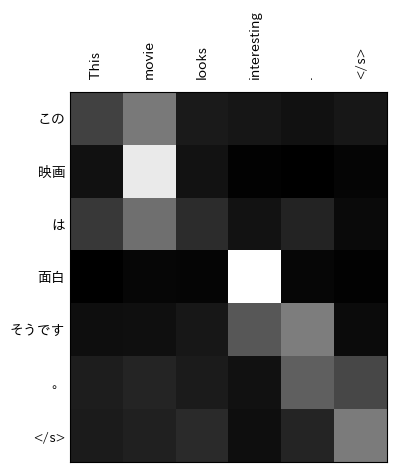

In [31]:
ids_en = sp_en.encode(text_en) + [eos_id]
ids_ja = sp_ja.encode(text_ja) + [eos_id]
ticks_x = list(map(lambda x: sp_en.id_to_piece(x).replace("▁", ""), ids_en))
ticks_y = list(map(lambda x: sp_ja.id_to_piece(x).replace("▁", ""), ids_ja))

plt.figure()
plt.imshow(weights.detach(), cmap="gray")
plt.xticks(range(len(ticks_x)), ticks_x, rotation=90, position=(0, 1.05), va="bottom")
plt.yticks(range(len(ticks_y)), ticks_y)
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0);

横がDecoderの時間軸、縦がEncoderの時間軸。Decoderが各時刻でどのトークンに着目しているかが色で表されている。白いほど強く着目されている。

例えば、左から二列目は、『movie』より前のトークン（BOS, This）を文脈として与えたときに『映画』に着目して推論を行っている、と解釈する。「『movie』を与えたとき」ではないので注意。『movie』を予測する際に『映画』に着目しているとも見られる。ただこの説明は少し不適切で、ここではモデルによる実際の翻訳結果を与えていないため、その単語が本当に予測されているかは分からない。『interesting』の場合は上位に予測されることが先の実験で確認されたが、それ以外のトークンについては不明。

『interesting』は『面白』、『movie』は『映画』と、トークン単位での翻訳結果と一致するように着目されていることが分かる。他にも、薄い色ではあるが、『This』と『この』、『.』と『。』、『EOS』と『EOS』といった対応も見られる。

Attentionを導入することでモデルの解釈性が上がり、解釈結果がこのように我々の直感と即していると面白いね。